# Analisis Glucometer Noninvasive

### NAMA: RADHITE MAJID SUKARDI
### NIM: 081911733035

#### S1 - TEKNIK BIOMEDIS, FAKULTAS SAINS DAN TEKNOLOGI, UNIVERSITAS AIRLANGGA
#### 2023

## Library

In [307]:
import pandas as pd
from pandas import Series
import matplotlib.pyplot as plt #other command: from matplotlib import pyplot as plt
from scipy.stats import kurtosis
from scipy import signal
from scipy import arange
import numpy as np
import math
from peakdetect import peakdetect
import pywt
import warnings
import os
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import MinMaxScaler
from tabulate import tabulate
import pickle

warnings.filterwarnings("ignore")

## 1. Body Mass Index (BMI)

In [308]:
def bmi_fun(ppgRaw): #beratBadan (KG), tinggiBadan (CM)
    bb = co4
    tb = co3/100
    result = round(bb/tb**2, 3)
    return result

## 2. Peak-to-Peak [Standard Deviation (Amplitude), Kurtosis (Interval), Mean Absolute Deviation (Amplitude)]

In [309]:
def pp_fun(ppgRaw):
    
    #Deteksi PP:
    peaks = peakdetect(co2, lookahead=20) 
    # Lookahead is the distance to look ahead from a peak to determine if it is the actual peak. 
    # Change lookahead as necessary 
    higherPeaks = np.array(peaks[0])
    lowerPeaks = np.array(peaks[1])
    
    #Inisial untuk variabel PP
    np.set_printoptions(suppress=True) #Agar tidak bernilai E+
    hiNum = higherPeaks[:,0]
    loNum = lowerPeaks[:,0]
    
    #Merapikan PP pada ujung awal dan akhir signal
    if loNum[0] < hiNum[0]: #Mengecualikan low-peak pertama jika berada terawal
        loNum = loNum[1:]
    if hiNum[-1] > loNum[-1]: #Mengecualikan high-peak terakhir jika berada terakhir
        hiNum = hiNum[:-1]
    
    #Index to volt
    hiVolt = []
    loVolt = []

    for i in hiNum:
        hiVolt.append(co2[i])
    for i in loNum:
        loVolt.append(co2[i])
        
    #Interval
    interval_values = []
    for i in higherPeaks[:,0]:
        if i == higherPeaks[0,0]:
            beNum = i
        else:
            intervalFormula = abs(co1[i]-co1[beNum])
            beNum = i
            interval_values.append(intervalFormula)
    
    #Amplitude
    amplitude_values = []
    for i in range(len(higherPeaks[:,0]) - 1):
        amplitudeFormula = abs(hiVolt[i] - loVolt[i])
        amplitude_values.append(amplitudeFormula)
        
    #2.1. Standar Deviasi
    #PANDAS: print(ppgRaw.std()) atau NUMPY: print(np.std(ppgRaw))
    #Standar Deviasi di kolom tertentu dengan contoh: print(ppgRaw['ppg_g'].std())
    #std di pd dan np berbeda secara default, selengkapnya: https://pub.towardsai.net/here-is-why-you-probably-use-numpy-std-incorrectly-276c40aaf82e
    STD = round(np.std(amplitude_values), 3)
    #STD = STD.to_numpy()
    
    #2.2. Kurtosis (Standard Deviation of Interval)
    KURT = round(kurtosis(interval_values, axis = 0, fisher=False, bias =True), 3)
    
    #2.3. Mean Absolute Deviation (MAD)
    series = pd.Series(amplitude_values) #MAD perlu tipe series (menurun); csv merupakan tipe series
    #amplitude_values = np.array(amplitude_values)
    MAD = round(series.mad(), 3)
    #MAD = MAD.to_numpy()
    
    return STD, KURT, MAD

## 3. Detrended Fluctuation Analysis (DFA)

In [310]:
#DFA
def dfa_fun(signal):
    
    signal = co2
    
    # Calculate cumulative sum of the signal
    cumsum = np.cumsum(signal - np.mean(signal))
    
    # Calculate the profile or integrated signal
    profile = cumsum - np.arange(len(signal)) * np.mean(signal)
    
    # Divide the profile into non-overlapping segments
    window_sizes = np.logspace(1, np.log10(len(signal)//4), 10).astype(int)
    fluctuation = np.zeros(len(window_sizes))
    
    for i, window in enumerate(window_sizes):
        # Calculate the local trend by fitting a polynomial of order 1 (linear)
        local_trend = np.polyfit(np.arange(window), profile[:window], 1)
        
        # Calculate the detrended fluctuation within each segment
        detrended_segment = profile[:window] - np.polyval(local_trend, np.arange(window))
        fluctuation[i] = np.sqrt(np.mean(detrended_segment**2))
    
    # Fit a line to the fluctuation values in log-log space to obtain the DFA exponent
    alpha = np.polyfit(np.log(window_sizes), np.log(fluctuation), 1)[0]
    alpha = round(alpha, 3)
    
    return alpha

## 4. Power Spectral Density (PSD)

In [311]:
#PSD
def psd_fun(signal):
    signal = co2
    duration = round(co1[int(len(co1)) - 1], 1)
    sampling_rate = len(signal)/duration
    # Compute the one-sided PSD using the FFT algorithm
    freqs, psd = plt.psd(signal, NFFT=len(signal), Fs=sampling_rate, window=plt.mlab.window_hanning)
    psd_mean = round(np.mean(freqs), 3)
    
    return psd_mean

## 5. Wavelet Entropy (WE)

In [312]:
#WE
def we_fun(signal, wavelet='db4', level=4, entropy='tsallis'):
    signal = co2
    # Perform wavelet decomposition
    coeffs = pywt.wavedec(signal, wavelet, level=level)
    
    wavelet_entropies = []
    
    for c in coeffs:
        # Calculate normalized wavelet coefficients
        nwc = np.abs(c) / np.sum(np.abs(c))
        
        # Calculate probability density function
        pdf, _ = np.histogram(nwc, bins='auto', density=True)
        
        # Remove zero probabilities to avoid errors in entropy calculation
        pdf = pdf[np.nonzero(pdf)]
        
        # Calculate entropy
        if entropy == 'shannon':
            entropy_val = -np.sum(pdf * np.log2(pdf))
        elif entropy == 'tsallis':
            q = 2  # You can adjust the value of q for Tsallis entropy
            entropy_val = np.sum(pdf ** q - pdf)
        else:
            raise ValueError("Invalid entropy measure. Choose either 'shannon' or 'tsallis'.")
        
        wavelet_entropies.append(entropy_val)
    average_entropy = np.mean(wavelet_entropies)
    #return average_entropy
    
    return round(np.mean(wavelet_entropies), 3)  # You can also use np.sum() instead of np.mean() to get the sum of entropies

## Clarke Error Grid Analysis (CEGA)

In [313]:
# Source: https://github.com/suetAndTie/ClarkeErrorGrid
def clarke_error_grid(ref_values, pred_values, title_string):

    #Checking to see if the lengths of the reference and prediction arrays are the same
    assert (len(ref_values) == len(pred_values)), "Unequal number of values (reference : {}) (prediction : {}).".format(len(ref_values), len(pred_values))

    #Checks to see if the values are within the normal physiological range, otherwise it gives a warning
    if max(ref_values) > 400 or max(pred_values) > 400:
        print("Input Warning: the maximum reference value {} or the maximum prediction value {} exceeds the normal physiological range of glucose (<400 mg/dl).").format(max(ref_values), max(pred_values))
    if min(ref_values) < 0 or min(pred_values) < 0:
        print ("Input Warning: the minimum reference value {} or the minimum prediction value {} is less than 0 mg/dl.").format(min(ref_values),  min(pred_values))

    #Clear plot
    plt.clf()

    #Set up plot
    plt.scatter(ref_values, pred_values, marker='o', color='black', s=8)
    plt.title(title_string + " Clarke Error Grid")
    plt.xlabel("Reference Concentration (mg/dl)")
    plt.ylabel("Prediction Concentration (mg/dl)")
    plt.xticks([0, 50, 100, 150, 200, 250, 300, 350, 400])
    plt.yticks([0, 50, 100, 150, 200, 250, 300, 350, 400])
    plt.gca().set_facecolor('white')

    #Set axes lengths
    plt.gca().set_xlim([0, 400])
    plt.gca().set_ylim([0, 400])
    plt.gca().set_aspect((400)/(400))

    #Plot zone lines
    plt.plot([0,400], [0,400], ':', c='black')                      #Theoretical 45 regression line
    plt.plot([0, 175/3], [70, 70], '-', c='black')
    #plt.plot([175/3, 320], [70, 400], '-', c='black')
    plt.plot([175/3, 400/1.2], [70, 400], '-', c='black')           #Replace 320 with 400/1.2 because 100*(400 - 400/1.2)/(400/1.2) =  20% error
    plt.plot([70, 70], [84, 400],'-', c='black')
    plt.plot([0, 70], [180, 180], '-', c='black')
    plt.plot([70, 290],[180, 400],'-', c='black')
    # plt.plot([70, 70], [0, 175/3], '-', c='black')
    plt.plot([70, 70], [0, 56], '-', c='black')                     #Replace 175.3 with 56 because 100*abs(56-70)/70) = 20% error
    # plt.plot([70, 400],[175/3, 320],'-', c='black')
    plt.plot([70, 400], [56, 320],'-', c='black')
    plt.plot([180, 180], [0, 70], '-', c='black')
    plt.plot([180, 400], [70, 70], '-', c='black')
    plt.plot([240, 240], [70, 180],'-', c='black')
    plt.plot([240, 400], [180, 180], '-', c='black')
    plt.plot([130, 180], [0, 70], '-', c='black')

    #Add zone titles
    plt.text(30, 15, "A", fontsize=15)
    plt.text(370, 260, "B", fontsize=15)
    plt.text(280, 370, "B", fontsize=15)
    plt.text(160, 370, "C", fontsize=15)
    plt.text(160, 15, "C", fontsize=15)
    plt.text(30, 140, "D", fontsize=15)
    plt.text(370, 120, "D", fontsize=15)
    plt.text(30, 370, "E", fontsize=15)
    plt.text(370, 15, "E", fontsize=15)

    #Statistics from the data
    zone = [0] * 5
    for i in range(len(ref_values)):
        if (ref_values[i] <= 70 and pred_values[i] <= 70) or (pred_values[i] <= 1.2*ref_values[i] and pred_values[i] >= 0.8*ref_values[i]):
            zone[0] += 1    #Zone A

        elif (ref_values[i] >= 180 and pred_values[i] <= 70) or (ref_values[i] <= 70 and pred_values[i] >= 180):
            zone[4] += 1    #Zone E

        elif ((ref_values[i] >= 70 and ref_values[i] <= 290) and pred_values[i] >= ref_values[i] + 110) or ((ref_values[i] >= 130 and ref_values[i] <= 180) and (pred_values[i] <= (7/5)*ref_values[i] - 182)):
            zone[2] += 1    #Zone C
        elif (ref_values[i] >= 240 and (pred_values[i] >= 70 and pred_values[i] <= 180)) or (ref_values[i] <= 175/3 and pred_values[i] <= 180 and pred_values[i] >= 70) or ((ref_values[i] >= 175/3 and ref_values[i] <= 70) and pred_values[i] >= (6/5)*ref_values[i]):
            zone[3] += 1    #Zone D
        else:
            zone[1] += 1    #Zone B

    return plt, zone

## TRAINING DATASET

[['aaron.csv', 16.706, 0.37, 3.997, 0.302, 0.975, 0.08, 177497.247, 93.0],
 ['addin.csv', 19.253, 0.04, 1.836, 0.031, 1.236, 0.11, 161995.064, 78.0],
 ['adit19.csv', 18.929, 0.054, 1.7, 0.043, 0.728, 0.116, 139102.151, 93.0],
 ['afiq19.csv', 31.603, 0.03, 3.187, 0.021, 0.93, 0.126, 158095.535, 95.0],
 ['aje.csv', 23.951, 0.288, 1.556, 0.22, 1.489, 0.094, 150537.6, 86.0],
 ['alfin.csv', 34.351, 0.283, 2.244, 0.253, 1.407, 0.103, 156322.881, 108.0],
 ['ardan.csv', 25.606, 0.255, 2.501, 0.217, 1.343, 0.084, 157286.867, 93.0],
 ['ardian.csv', 18.987, 0.217, 1.816, 0.176, 1.27, 0.08, 143735.822, 77.0],
 ['ario.csv', 15.777, 0.251, 2.131, 0.2, 1.149, 0.079, 208979.397, 89.0],
 ['bintang.csv', 28.721, 0.211, 2.623, 0.18, 1.387, 0.087, 143524.241, 86.0],
 ['denil.csv', 29.752, 0.243, 2.196, 0.187, 1.108, 0.084, 165588.057, 91.0],
 ['derry.csv', 19.362, 0.295, 1.692, 0.252, 1.36, 0.095, 164893.11, 73.0],
 ['edim.csv', 30.76, 0.232, 2.559, 0.204, 1.893, 0.112, 159034.429, 93.0],
 ['excell.csv', 

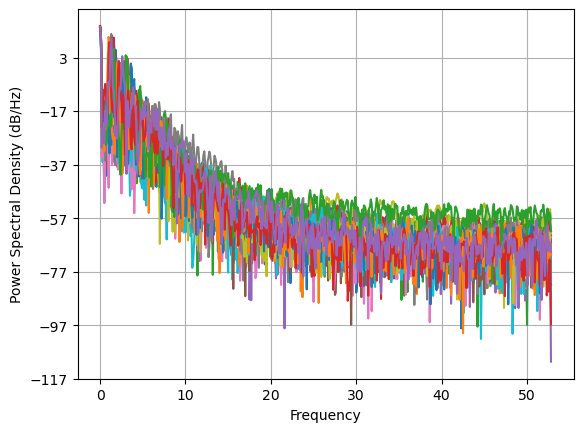

In [314]:
#TRAINING DATASET
trainGlucose = []

# Set the path to the directory containing the CSV files
folder_path = 'train'

# Iterate over all files in the directory
for file_name in os.listdir(folder_path):
    if file_name.endswith('.csv'):
        file_path = os.path.join(folder_path, file_name)
        
        # Perform calculations on the CSV file
        df = pd.read_csv(file_path)
        
        #Variabel kolom
        co1 = df.iloc[:,0] #column of time
        co2 = df.iloc[:,1] #column of volt
        co3 = df.iloc[0,2] #column of height
        co4 = df.iloc[0,3] #column of weight
        co5 = df.iloc[0,4] #column of invasive

        bmi = bmi_fun(df)
        pp = pp_fun(df)
        dfa = dfa_fun(df)
        psd = psd_fun(df)
        we = we_fun(df)
        trainGlucose.append([file_name, bmi, pp[0], pp[1], pp[2], dfa, psd, we, co5])

trainGlucose


## TEST DATASET

[['adit20.csv', 30.071, 0.329, 3.039, 0.26, 1.427, 0.115, 208349.284, 93.0],
 ['bagus.csv', 27.16, 0.119, 2.641, 0.101, 0.87, 0.079, 179969.538, 103.0],
 ['daf.csv', 21.514, 0.355, 1.427, 0.264, 1.88, 0.091, 155147.203, 99.0],
 ['khouliya.csv', 21.411, 0.352, 2.193, 0.275, 1.306, 0.076, 141549.933, 88.0],
 ['rad01.csv', 25.631, 0.175, 1.813, 0.154, 1.716, 0.13, 177559.902, 86.0],
 ['rad02.csv', 25.631, 0.007, 2.359, 0.006, 2.506, 0.142, 174798.223, 71.0],
 ['rad03.csv', 25.631, 0.0, 1.683, 0.0, 1.317, 0.141, 169685.378, 79.0],
 ['rad04.csv', 25.631, 0.005, 2.062, 0.003, 1.195, 0.135, 163751.687, 93.0],
 ['rad05.csv', 25.631, 0.198, 2.021, 0.168, 1.139, 0.094, 156564.049, 84.0],
 ['rik.csv', 22.837, 0.435, 1.603, 0.342, 0.979, 0.117, 172704.017, 91.0]]

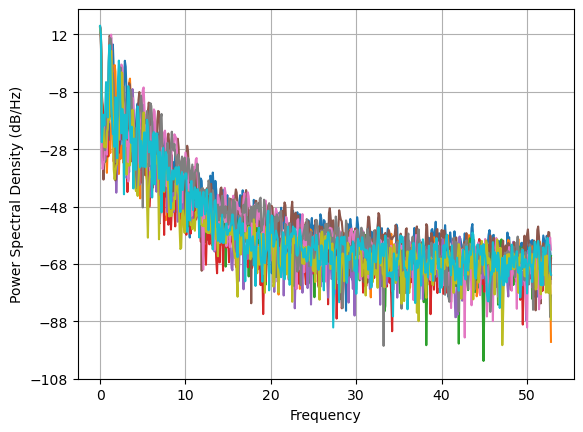

In [315]:
#TEST DATASET
testGlucose = []

# Set the path to the directory containing the CSV files
folder_path = 'test'

# Iterate over all files in the directory
for file_name in os.listdir(folder_path):
    if file_name.endswith('.csv'):
        file_path = os.path.join(folder_path, file_name)
        
        # Perform calculations on the CSV file
        df = pd.read_csv(file_path)
        
        #Variabel kolom
        co1 = df.iloc[:,0] #column of time
        co2 = df.iloc[:,1] #column of volt
        co3 = df.iloc[0,2] #column of height
        co4 = df.iloc[0,3] #column of weight
        co5 = df.iloc[0,4] #column of invasive

        bmi = bmi_fun(df)
        pp = pp_fun(df)
        dfa = dfa_fun(df)
        psd = psd_fun(df)
        we = we_fun(df)
        testGlucose.append([file_name, bmi, pp[0], pp[1], pp[2], dfa, psd, we, co5])

testGlucose

In [316]:
testGlucose[0]

['adit20.csv', 30.071, 0.329, 3.039, 0.26, 1.427, 0.115, 208349.284, 93.0]

## Neural Network

In [317]:
#newGlucose = [row[0:8] for row in myGlucose][25:30]
#[row[1:9] for row in testGlucose]

In [318]:
X_train = [row[1:8] for row in trainGlucose]
y_train = [row[8] for row in trainGlucose]
X_test = [row[1:8] for row in testGlucose]
y_test = [row[8] for row in testGlucose]

In [319]:
#X_test
y_train

[93.0,
 78.0,
 93.0,
 95.0,
 86.0,
 108.0,
 93.0,
 77.0,
 89.0,
 86.0,
 91.0,
 73.0,
 93.0,
 85.0,
 103.0,
 103.0,
 89.0,
 75.0,
 90.0,
 98.0,
 98.0,
 79.0,
 83.0,
 85.0,
 106.0]

In [320]:
#Scaling Data

min_max_scaler = MinMaxScaler()
min_max_scaler.fit(X_train)
X_train = min_max_scaler.transform(X_train)
X_test = min_max_scaler.transform(X_test)

print(X_test)

[[ 0.76886666  0.32421479  0.48690021  0.33911883  0.63650546  0.76595745
   0.98530531]
 [ 0.61228551  0.11144883  0.369738    0.12683578  0.20202808  0.
   0.58149488]
 [ 0.30859018  0.35055724  0.01236385  0.34445928  0.98985959  0.25531915
   0.22830223]
 [ 0.30304986  0.34751773  0.23785693  0.35914553  0.54212168 -0.06382979
   0.03482906]
 [ 0.53004142  0.16818642  0.12599352  0.1975968   0.86193448  1.08510638
   0.54720859]
 [ 0.53004142 -0.00202634  0.28672358  0.          1.47815913  1.34042553
   0.50791315]
 [ 0.53004142 -0.00911854  0.08772446 -0.00801068  0.55070203  1.31914894
   0.43516337]
 [ 0.53004142 -0.00405268  0.19929349 -0.00400534  0.45553822  1.19148936
   0.35073392]
 [ 0.53004142  0.19148936  0.18722402  0.21628838  0.41185647  0.31914894
   0.24846228]
 [ 0.37975364  0.43161094  0.06417427  0.44859813  0.28705148  0.80851064
   0.47811506]]


In [321]:
y_test

[93.0, 103.0, 99.0, 88.0, 86.0, 71.0, 79.0, 93.0, 84.0, 91.0]

In [322]:
pd.DataFrame(y_test).to_csv('00train.csv')

In [345]:
clf = MLPClassifier(hidden_layer_sizes=(3,2), activation='relu', solver='adam', learning_rate_init=0.1, max_iter=500, verbose=True)
clf.fit(X_train, y_train)

Iteration 1, loss = 2.83328981
Iteration 2, loss = 2.75516013
Iteration 3, loss = 2.72731248
Iteration 4, loss = 2.72158229
Iteration 5, loss = 2.72621900
Iteration 6, loss = 2.72499529
Iteration 7, loss = 2.72549170
Iteration 8, loss = 2.70666865
Iteration 9, loss = 2.69820396
Iteration 10, loss = 2.68391730
Iteration 11, loss = 2.66483392
Iteration 12, loss = 2.65587782
Iteration 13, loss = 2.64717259
Iteration 14, loss = 2.62381040
Iteration 15, loss = 2.61237224
Iteration 16, loss = 2.58068294
Iteration 17, loss = 2.56914402
Iteration 18, loss = 2.54048559
Iteration 19, loss = 2.51589209
Iteration 20, loss = 2.49799144
Iteration 21, loss = 2.47801663
Iteration 22, loss = 2.46378947
Iteration 23, loss = 2.44140624
Iteration 24, loss = 2.41723515
Iteration 25, loss = 2.39391906
Iteration 26, loss = 2.36860561
Iteration 27, loss = 2.35083315
Iteration 28, loss = 2.32939220
Iteration 29, loss = 2.31071292
Iteration 30, loss = 2.29278783
Iteration 31, loss = 2.26957997
Iteration 32, los

MLPClassifier(hidden_layer_sizes=(3, 2), learning_rate_init=0.1, max_iter=500,
              verbose=True)

In [346]:
clf.intercepts_

[array([-0.41604981, -0.53620708, -0.68291326]),
 array([-4.89473367, -0.01701852]),
 array([ 4.74646467,  4.75153113, -0.5815871 , -6.11499148, -8.17410746,
         4.76061139, -4.29823676, -6.67887584,  5.46354939,  4.75466051,
         4.77275441,  5.32177259, -4.16607999,  4.99270767,  5.45664976,
        -7.00959724,  2.06850258])]

In [324]:
y_pred = clf.predict(X_test)

In [325]:
print(y_test)
print(y_pred)

[93.0, 103.0, 99.0, 88.0, 86.0, 71.0, 79.0, 93.0, 84.0, 91.0]
[98. 89. 73. 86. 98. 79. 93. 93. 93. 98.]


In [326]:
selisih = []
for i in range(len(y_test)):
    slh = y_test[i] - y_pred[i]
    selisih.append(slh)
selisih

[-5.0, 14.0, 26.0, 2.0, -12.0, -8.0, -14.0, 0.0, -9.0, -7.0]

In [327]:
nama = [row[0] for row in testGlucose]
hD = ['Nama','Invasif','Non-invasif','Galat']
table = zip(nama, y_test, y_pred, selisih)
print(tabulate(table, headers=hD, tablefmt='grid'))

+--------------+-----------+---------------+---------+
| Nama         |   Invasif |   Non-invasif |   Galat |
+==============+===========+===============+=========+
| adit20.csv   |        93 |            98 |      -5 |
+--------------+-----------+---------------+---------+
| bagus.csv    |       103 |            89 |      14 |
+--------------+-----------+---------------+---------+
| daf.csv      |        99 |            73 |      26 |
+--------------+-----------+---------------+---------+
| khouliya.csv |        88 |            86 |       2 |
+--------------+-----------+---------------+---------+
| rad01.csv    |        86 |            98 |     -12 |
+--------------+-----------+---------------+---------+
| rad02.csv    |        71 |            79 |      -8 |
+--------------+-----------+---------------+---------+
| rad03.csv    |        79 |            93 |     -14 |
+--------------+-----------+---------------+---------+
| rad04.csv    |        93 |            93 |       0 |
+---------

## Simpan NN

In [328]:
# with open('ann_005','wb') as r:
#     pickle.dump(clf,r)

## Muat NN

In [329]:
print(ann.fit(X_train, y_train))

Iteration 1, loss = 2.76830899
Iteration 2, loss = 2.62567405
Iteration 3, loss = 2.41391762
Iteration 4, loss = 2.23821776
Iteration 5, loss = 2.04670089
Iteration 6, loss = 1.91237020
Iteration 7, loss = 1.77875394
Iteration 8, loss = 1.63652803
Iteration 9, loss = 1.51920758
Iteration 10, loss = 1.42612130
Iteration 11, loss = 1.32720233
Iteration 12, loss = 1.22351928
Iteration 13, loss = 1.11824263
Iteration 14, loss = 1.01209061
Iteration 15, loss = 0.91589826
Iteration 16, loss = 0.84469150
Iteration 17, loss = 0.76579071
Iteration 18, loss = 0.68931723
Iteration 19, loss = 0.63378689
Iteration 20, loss = 0.60222552
Iteration 21, loss = 0.64903141
Iteration 22, loss = 0.55412915
Iteration 23, loss = 0.50938000
Iteration 24, loss = 0.52033619
Iteration 25, loss = 0.42977259
Iteration 26, loss = 0.46668471
Iteration 27, loss = 0.40904367
Iteration 28, loss = 0.39784144
Iteration 29, loss = 0.37506958
Iteration 30, loss = 0.36120846
Iteration 31, loss = 0.35563649
Iteration 32, los

In [330]:
with open('ann_004','rb') as r:
    ann = pickle.load(r)
load_y_pred = ann.predict(X_test)
load_selisih = []
for i in range(len(y_test)):
    slh = y_test[i] - load_y_pred[i]
    load_selisih.append(slh)
nama = [row[0] for row in testGlucose]
r_square = []
for i in range(len(y_test)):
    r = 1 - (abs(load_selisih[i])/y_test[i])
    r = round(r, 3)
    r_square.append(r)

hD = ['Nama','Invasif','Non-invasif','Galat','R^2']
table = zip(nama, y_test, load_y_pred, load_selisih, r_square)
print(y_test)
print()
print(tabulate(table, headers=hD, tablefmt='grid'))

[93.0, 103.0, 99.0, 88.0, 86.0, 71.0, 79.0, 93.0, 84.0, 91.0]

+--------------+-----------+---------------+---------+-------+
| Nama         |   Invasif |   Non-invasif |   Galat |   R^2 |
+==============+===========+===============+=========+=======+
| adit20.csv   |        93 |            95 |      -2 | 0.978 |
+--------------+-----------+---------------+---------+-------+
| bagus.csv    |       103 |            83 |      20 | 0.806 |
+--------------+-----------+---------------+---------+-------+
| daf.csv      |        99 |            73 |      26 | 0.737 |
+--------------+-----------+---------------+---------+-------+
| khouliya.csv |        88 |            86 |       2 | 0.977 |
+--------------+-----------+---------------+---------+-------+
| rad01.csv    |        86 |            85 |       1 | 0.988 |
+--------------+-----------+---------------+---------+-------+
| rad02.csv    |        71 |            85 |     -14 | 0.803 |
+--------------+-----------+---------------+---------+-

In [342]:
ann.coefs_

[array([[ 0.47989925,  0.45610122,  0.43183363, -0.29953043,  0.32689056,
         -2.53513461, -2.11869546, -1.74471872,  1.00402831, -0.55722884],
        [ 1.97957285, -0.46376351,  0.81071389, -1.23612164, -0.71242854,
         -0.33193447, -1.96021657, -1.62075589,  0.90460064, -0.12585585],
        [-2.04796672, -0.35457419, -0.98888727, -0.43007134, -1.13280986,
         -2.18021464, -1.30388764,  2.34346406,  0.20382684,  0.97087952],
        [ 1.13003161, -1.4276963 ,  1.12348572, -0.57642444, -0.44078235,
          0.67006557, -1.08207315, -1.55968948,  0.99697247,  0.10042144],
        [ 1.45382481, -0.70169795, -0.36693053,  0.93955705,  0.62955835,
          1.15908163,  0.88381715,  1.14879041,  0.57365544,  0.83887931],
        [-1.07381606, -0.45870394,  1.18869338, -2.13347765, -2.47629579,
          0.8806913 , -0.23632031,  0.93572739,  0.79839627, -0.13455179],
        [-2.78516517, -1.17635525, -1.2765847 , -1.48953777, -0.6057186 ,
          0.27474225, -0.5310919

In [343]:
ann.intercepts_

[array([ 0.61687801, -1.17531583, -0.50702573,  1.26793426,  0.46694549,
         0.56965213,  0.98382694,  0.72837787, -0.85424998,  1.37044055]),
 array([-0.00940159,  0.47607069,  1.80362455,  1.56098467, -1.08289754]),
 array([ 0.18520413, -0.62374605, -0.51523027, -1.11723682, -2.23322292,
        -0.62269901, -0.8373743 ,  1.55880236, -0.55066915, -1.72135424,
         1.20464836,  1.29107738, -0.137773  ,  1.86992745, -0.70511186,
         1.076321  , -0.74534925])]

In [ ]:
def Avg(lst):
    return sum(lst) / len(lst)

rerata_rSquare = Avg(r_square)
print('Rata-rata R^2:', round(rerata_rSquare, 3))

In [ ]:
print(ann.predict(X_test))

In [ ]:
plot, zone = clarke_error_grid(y_test, load_y_pred, "Linear Regression")
plot.show()